In [11]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math 

batch_size = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data_dir = './training_data/'
test_dir = './test_data/'

train_set = ImageFolder(data_dir,transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))
# train_set = ImageFolder(data_dir,transform = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))
test_set = ImageFolder(test_dir,transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))
# test_set = ImageFolder(test_dir,transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))


train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)




In [12]:
print(len(train_set))
print(len(test_set))

46
26


In [13]:
def Show_imgs(imgs, name,  size = 3, color = True):
  color_m ='jet'
  if color == False:
    color_m ='gray'
  print('******************' + name  +  '**************************')
  img_numbers = imgs.shape[0]
  rows = cols = math.ceil(np.sqrt(img_numbers))
  
  fig = plt.figure(figsize=(rows*size, cols*size))
  for i in range(0, rows*cols):
    fig.add_subplot(rows, cols,i+1)
    if i<img_numbers:
      plt.imshow(imgs[i].detach(), cmap = 'gray')
  plt.show()


******************Numero**************************


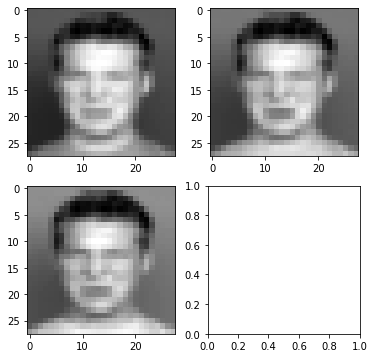

In [14]:
img, label = train_set[10]
Show_imgs(img, "Numero")

******************Numero**************************


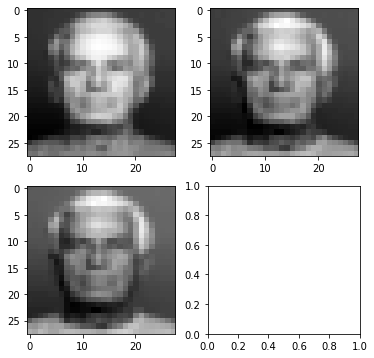

torch.Size([3, 28, 28])
torch.Size([1, 3, 28, 28])
torch.Size([1, 33, 13, 13])
********************************************


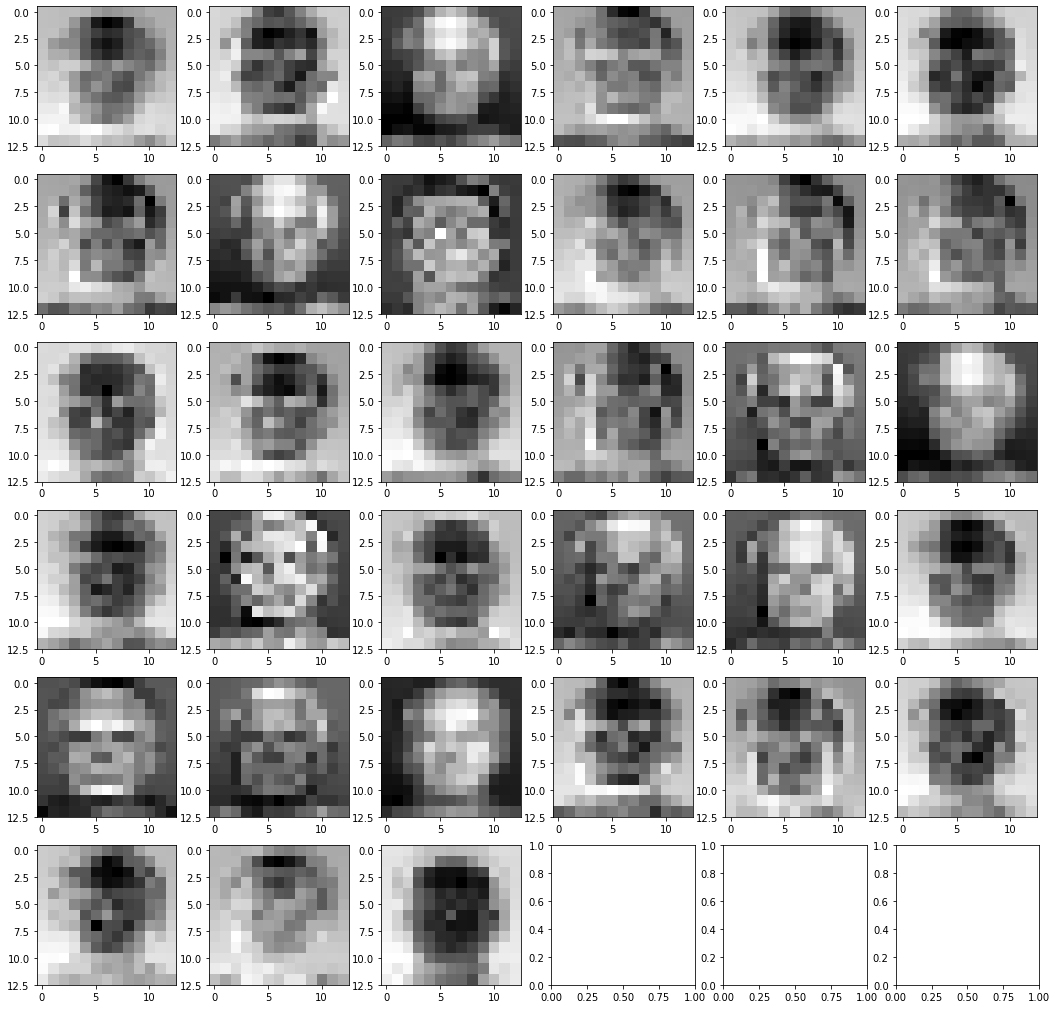

********************************************


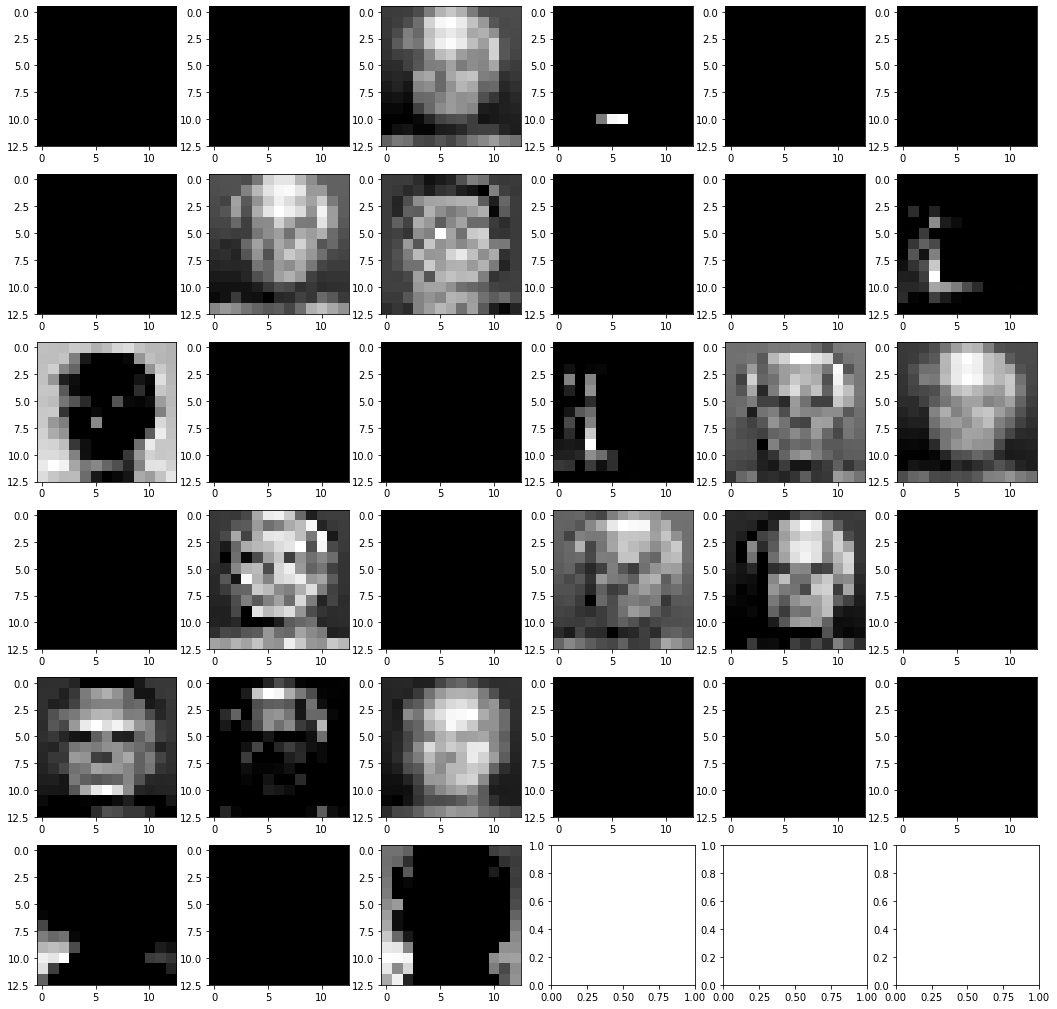

c:\users\kael\pycharmprojects\ia\venv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


********************************************


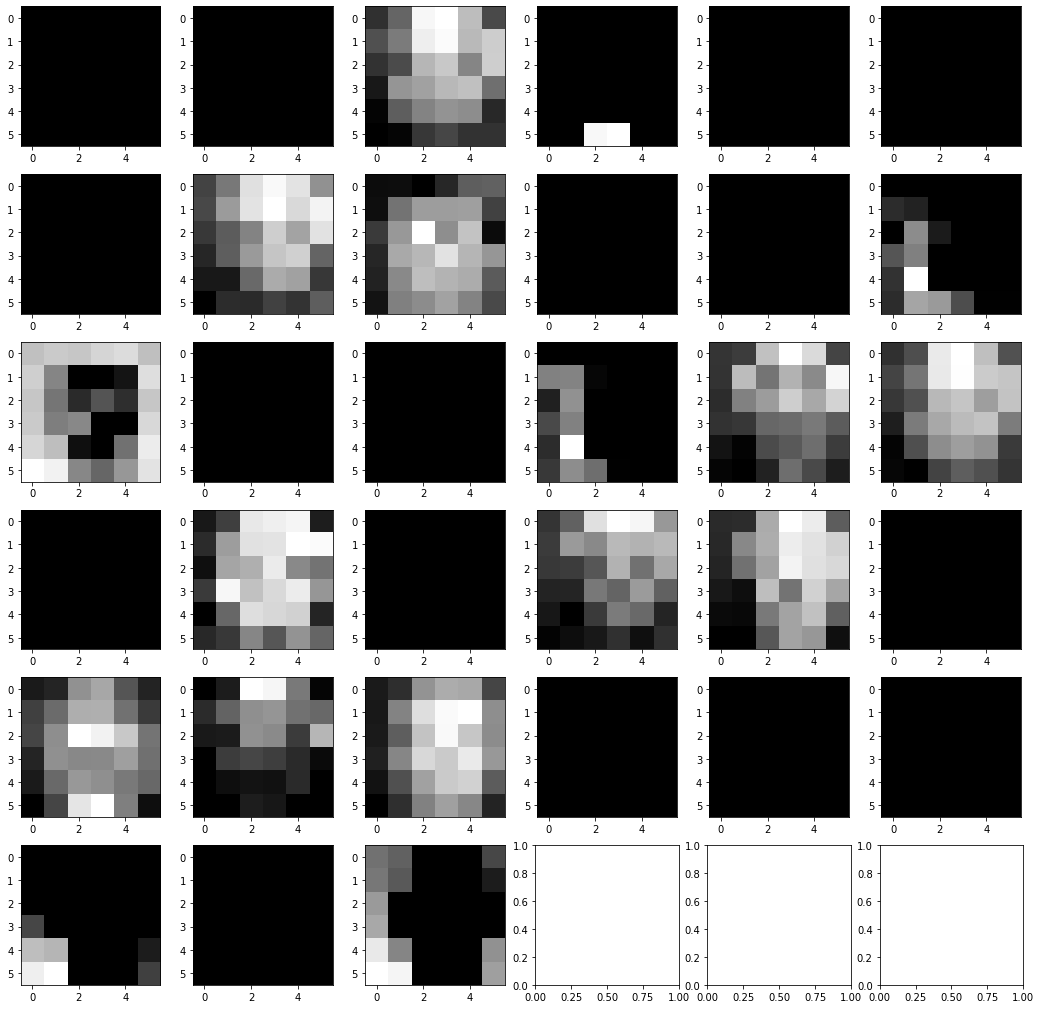

RuntimeError: Given groups=1, weight of size [16, 1, 1, 1], expected input[1, 3, 28, 28] to have 1 channels, but got 3 channels instead

In [16]:
img, label = train_set[30]
Show_imgs(img, "Numero")

#plt.imshow(transforms.ToPILImage()(img), cmap = 'gray')
# conv1 = nn.Conv2d(in_channels=1,out_channels=4, kernel_size=3, stride=(1,1), padding=1)
conv1 = nn.Conv2d(3, 33, 3, stride=2)


print(img.shape)
img = img.unsqueeze(0)
print(img.shape)

# [batch_size, Channel, H,W]

out =  conv1(img)
print(out.shape)
Show_imgs(out[0],"")
act = nn.ReLU()(out)
Show_imgs(act[0],"")

pool1 = nn.MaxPool2d(2,2)(act)
Show_imgs(pool1[0],"")


layer1 = nn.Sequential( nn.Conv2d(1,16,1,3,2) , nn.ReLU(), nn.MaxPool2d(2,2))

out = layer1(img)
#Show_imgs(out[0], "layer 1")

print("si")
print(out.shape)

out = out.reshape(out.size(0),-1)
print(out.shape)


for i in range(16):
  Show_imgs(layer1[0].weight[i],"layer 1 weight", 1)
#Show_imgs(layer1[0].weight,"layer 1 weight", 1)


In [17]:
#hypengrparameter 
num_classes = 6
learning_rate =  0.001
num_epochs = 20

class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5), padding=(2)),
            nn.MaxPool2d(kernel_size=(2,2), stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2), stride=2))
            
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 6)
#
        
    def forward(self, x):
        # out = self.layer1(x)
        # out = self.layer2(out)
        # out = out.reshape(out.size(0), -1)
        # out = self.fc(out)
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


 

In [18]:
model         = CNN(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
#loss_train    = train(model, optimizer, loss_fn, num_epochs)
#test(model)

# print([ e.shape  for e in model.fc.parameters()])

model.fc1.weight


Parameter containing:
tensor([[ 0.0116,  0.0214,  0.0106,  ...,  0.0239,  0.0126, -0.0252],
        [ 0.0206, -0.0066, -0.0243,  ..., -0.0131, -0.0031,  0.0378],
        [-0.0161, -0.0235,  0.0450,  ...,  0.0219,  0.0182, -0.0310],
        ...,
        [-0.0378,  0.0372, -0.0411,  ...,  0.0097,  0.0405, -0.0182],
        [-0.0268, -0.0099, -0.0460,  ...,  0.0097,  0.0036, -0.0183],
        [-0.0240, -0.0117, -0.0368,  ...,  0.0291,  0.0093,  0.0151]],
       requires_grad=True)

In [19]:
def train(model, optimizer, loos_fn, num_epochs):
  loss_vals = []
  running_loss =0.0
  # train the model
  total_step = len(train_loader)

  list_loss= []
  list_time = []
  j=0

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      list_loss.append(loss.item())
      list_time.append(j)
      j+=1
              
      if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
              
  print('Finished Training Trainset')
  return list_loss


In [20]:
def test(model):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 46 test images: {} %'.format(100 * correct / total))

In [ ]:
train(model,optimizer,loss_fn,20)

In [ ]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()


with torch.no_grad():
  model.to('cpu')
  img, label = test_set[25]
  img = img.unsqueeze(0)
  out = model(img)
  print(out)
  print ((out == out.max()).nonzero())
  
  out = model.layer1[0](img)
  Show(out, 'layer 1: Convolution output')
  out = model.layer1[1](out)
  Show(out, 'layer 1: Activation function output')
  out = model.layer1[2](out)
  Show(out, 'layer 1: Max-Pooling')
  
  
  out = model.layer2[0](out)
  Show(out, 'layer 2: Convolution output')
  out = model.layer2[1](out)
  Show(out, 'layer 2: Activation function output')
  out = model.layer2[2](out)
  Show(out, 'layer 2: Max-Pooling')
  

In [ ]:
img, label = train_set[40]
plt.imshow(transforms.ToPILImage()(img), cmap = 'gray')
img = img.unsqueeze(0)

conv = nn.Conv2d(in_channels=3,out_channels=1, kernel_size=5, stride=1, padding=1)
out = conv(img)

print("X")
print(img.shape)
print("Y")
print(out.shape)

conv2 = nn.Conv2d(in_channels=3,out_channels=1, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=3, stride=1, padding=1)
out = conv2(img)
out = conv3(out)


print("Entrada")
print(img.shape)

print(out.shape)

test(model)


In [ ]:
def visualize_model(model, num_images=26):
    was_training = model.training
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(train_set.classes[preds[j]]))
                plt.imshow(inputs.cpu().data[j].squeeze().permute(1,2,0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

visualize_model(model)
